_ELMED219-2021_. Alexander S. Lundervold, 10.01.2021.

# Introduction

In this notebook we'll have a look at how machine learning can be used on electronic health records data through a (small and simplified) example.

From data gathered from 100.000 patients, collected by Microsoft here https://microsoft.github.io/r-server-hospital-length-of-stay/index.html, we will try to predict the length of stay of patients admitted to the hospital. Such a system (if it was sufficiently robust and accurate) would be extremely valuable. For hospital resource management, i.e. managing personnel and planning for patient discharge at hospital departments.

By investigating what features have the largest explanatory power for a trained machine learning model, such a system could also potentially uncover interesting connections between journal data and patient conditions.

# Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from pathlib import Path
import seaborn as sns

In [2]:
DATA = Path('data')

# Load and inspect the data

The data set consists of three files:

In [3]:
LOS = pd.read_pickle(DATA/'hospital')
DICT = pd.read_excel(DATA/'Data_Dictionary.xlsx')
METADATA = pd.read_csv(DATA/'MetaData_Facilities.csv')

We'll take a look at all of them:

In [4]:
LOS.head()

,rcount,gender,facid,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,lengthofstay
0,0,0,1,1,False,False,False,False,False,False,...,14.20,140.361130,192.476913,12.0,1.390722,30.432417,96,6.5,4,3
1,5,0,0,2,False,False,False,False,False,False,...,4.10,136.731689,94.078506,8.0,0.943164,28.460516,61,6.5,1,7
2,1,0,1,3,False,False,False,False,False,False,...,8.90,133.058517,130.530518,12.0,1.065750,28.843811,64,6.5,2,3
3,0,0,0,4,False,False,False,False,False,False,...,9.40,138.994019,163.377029,12.0,0.906862,27.959007,76,6.5,1,1
4,0,0,4,5,False,False,False,True,False,True,...,9.05,138.634842,94.886658,11.5,1.242854,30.258926,67,5.6,2,4


In [5]:
LOS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   rcount                      100000 non-null  int32  
 1   gender                      100000 non-null  int32  
 2   facid                       100000 non-null  int32  
 3   eid                         100000 non-null  int32  
 4   dialysisrenalendstage       100000 non-null  bool   
 5   asthma                      100000 non-null  bool   
 6   irondef                     100000 non-null  bool   
 7   pneum                       100000 non-null  bool   
 8   substancedependence         100000 non-null  bool   
 9   psychologicaldisordermajor  100000 non-null  bool   
 10  depress                     100000 non-null  bool   
 11  psychother                  100000 non-null  bool   
 12  fibrosisandother            100000 non-null  bool   
 13  malnutrition   

In [6]:
DICT

,Index,Data fields,Type,Descriptions
0,NaN,LengthOfStay,NaN,NaN
1,1.0,eid,Integer,Unique Id of the hospital admission
2,2.0,vdate,String,Visit date
3,3.0,rcount,Integer,Number of readmissions within last 180 days
4,4.0,gender,String,Gender of the patient\nM or F
5,5.0,dialysisrenalendstage,String,Flag for renal disease during encounter
6,6.0,asthma,String,Flag for asthma during encounter
7,7.0,irondef,String,Flag for iron deficiency during encounter
8,8.0,pneum,String,Flag for pneumonia during encounter
9,9.0,substancedependence,String,Flag for substance dependence during encounter


In [7]:
METADATA

,Capacity,Id,Name
0,30,C,General Medicine 3 South
1,95,E,Behavioral 1 East
2,75,A,General Medicine 3 West
3,80,B,Pulmonary 2 West
4,100,D,Geriatrics 2 East


## Some simple observations



It seems that `LOS` is our main source of information. `DICT` provides useful information about the features in `LOS`, while `METADATA` contains information about the various hospital departments the data is collected from.

# Plots and further exploration

What is the distribution of length of stay?

In [8]:
LOS_value_count = LOS['lengthofstay'].value_counts()
LOS_value_count

1              17979
3              16068
4              14822
2              12825
5              12116
6              10362
7               7263
8               4652
more than 8     3913
Name: lengthofstay, dtype: int64

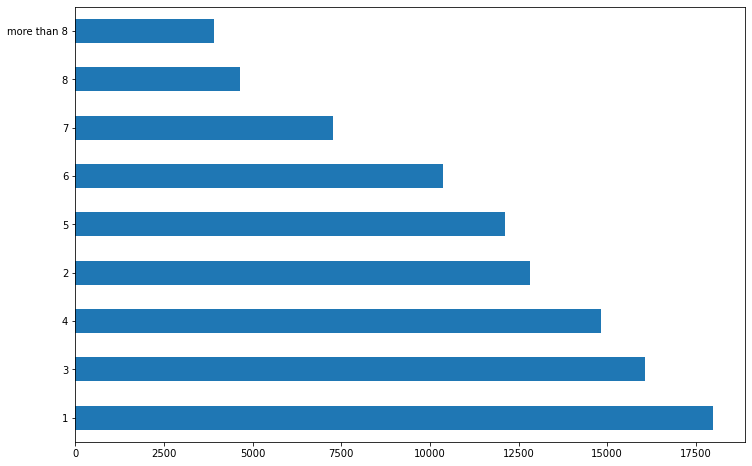

In [9]:
LOS_value_count.plot.barh(figsize=(12,8))
plt.show()

We note that the data set is pretty imbalanced. Most of the stays at the hospital are short. 

What's the gender distribution

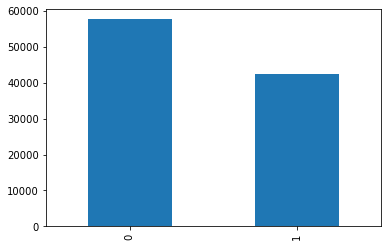

In [10]:
gender_counts = LOS['gender'].value_counts()
gender_counts.plot.bar()
plt.show()

A bit more men (0) than women (1). 

Is there a difference in how long they stay at the hospital?

In [11]:
# First we convert "more than 8" to the number 9, for plotting purposes:
LOS_tmp = LOS.copy()

D:\Anaconda3\envs\elmed219-2021\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


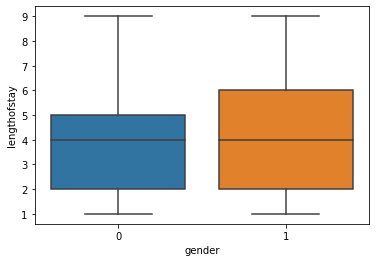

In [12]:
LOS_tmp['lengthofstay'].loc[LOS_tmp['lengthofstay'] == 'more than 8'] = 9 # Setter alle med "mer enn 8" til 9

LOS_tmp['lengthofstay'] = LOS_tmp['lengthofstay'].astype(int) # Skift til heltall

# Box plot:
ax = sns.boxplot(x='gender', y='lengthofstay', data=LOS_tmp)

## Correlations

How do the numerical features correlate to length of stay?

Here's the feature descriptions again:

In [13]:
DICT

,Index,Data fields,Type,Descriptions
0,NaN,LengthOfStay,NaN,NaN
1,1.0,eid,Integer,Unique Id of the hospital admission
2,2.0,vdate,String,Visit date
3,3.0,rcount,Integer,Number of readmissions within last 180 days
4,4.0,gender,String,Gender of the patient\nM or F
5,5.0,dialysisrenalendstage,String,Flag for renal disease during encounter
6,6.0,asthma,String,Flag for asthma during encounter
7,7.0,irondef,String,Flag for iron deficiency during encounter
8,8.0,pneum,String,Flag for pneumonia during encounter
9,9.0,substancedependence,String,Flag for substance dependence during encounter


We check the correlations with `lengthofstay`:

In [14]:
correlation_matrix = LOS_tmp.corr()
correlation_matrix['lengthofstay'].sort_values(ascending=False)

lengthofstay                  1.000000
rcount                        0.752818
facid                         0.363066
psychologicaldisordermajor    0.289187
hemo                          0.213832
irondef                       0.192063
psychother                    0.185655
malnutrition                  0.169207
dialysisrenalendstage         0.162927
substancedependence           0.147174
bloodureanitro                0.141912
pneum                         0.132303
depress                       0.122732
asthma                        0.084388
gender                        0.068686
fibrosisandother              0.060492
pulse                         0.006616
secondarydiagnosisnonicd9     0.006339
eid                           0.001203
bmi                          -0.000181
glucose                      -0.002465
sodium                       -0.002510
creatinine                   -0.004156
neutrophils                  -0.011813
respiration                  -0.019343
hematocrit               

## Observations

- `rcount` is highly correlated to length of stay. The number of hospital visits during the last 180 days says a lot about expected length of stay. 
- `facid` is also quite correlated. That could be caused by varying capacity of the different departments, and the different patient population they serve.

Most patients haven't been to the hospital during the last 180 days, but some are frequent guests:

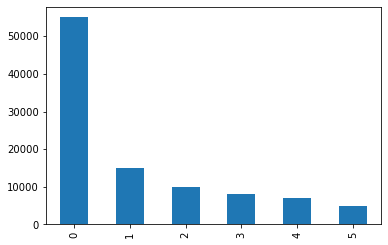

In [15]:
LOS['rcount'].value_counts().plot.bar()
plt.show()

The capacity of the different departments varies:

In [16]:
METADATA

,Capacity,Id,Name
0,30,C,General Medicine 3 South
1,95,E,Behavioral 1 East
2,75,A,General Medicine 3 West
3,80,B,Pulmonary 2 West
4,100,D,Geriatrics 2 East


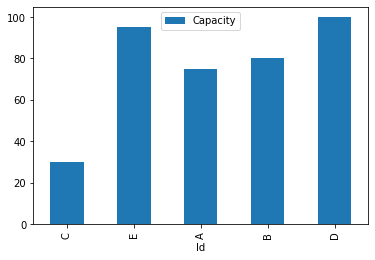

In [17]:
METADATA.plot(x='Id', y='Capacity', kind='bar')
plt.show()

# Let's try to make a predictive model

We treat this as a classification problem. I.e. 
> Is the expected length of stay 1, 2, 3, 4, 5, 6, 7, 8 or more than 8 days?

It's also possible to treat it like regression. Feel free to try!

In [18]:
X = LOS.drop('lengthofstay', axis=1)
y = LOS['lengthofstay']

## Separate a test set

To simulate the real situation where our model is used to predict length of stay as a new patient arrives, we set aside a test set to evaluate the model.

In [19]:
from sklearn.model_selection import train_test_split

We used stratified splitting (`stratify=y` below) to ensure that the length of stay distribution is the same in the training and test sets.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Select a model

We'll try a random forest classifier:

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) 
# n_jobs=-1 to use all available CPUs on the computer.

We train the model:

In [23]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

...and compute its accuracy on the test data:

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
y_pred = rf.predict(X_test)

In [26]:
accuracy_score(y_test, y_pred)

0.66676

The model predicts the length of stay on the test data with an accuracy of about 67%.

# Evaluating the result

Is this a good result? What features are used by the model in making its predictions?

## Confusion matrix

Confusion matrices are very useful tools when evaluating classifiers. They simply count the number of correct classifications and the number of misclassifications of all kinds:

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [29]:
from utils import plot_confusion_matrix

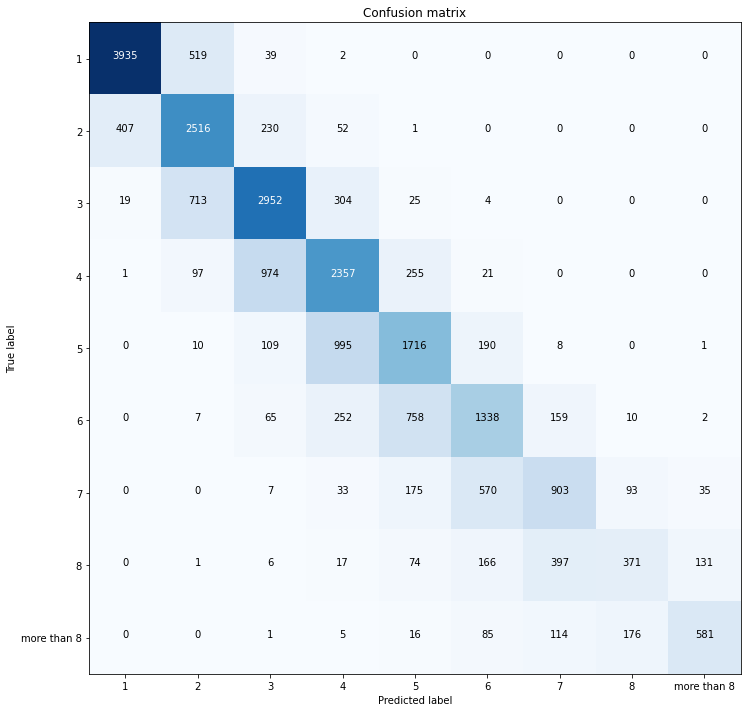

In [30]:
fig, ax = plt.subplots(figsize=(12,10))
_ = plot_confusion_matrix(cm, classes=np.unique(y_test), ax=ax)

## Feature importance

We know that looking at feature importance can be useful:

In [31]:
importances = rf.feature_importances_
# Find index of those with highest importance, sorted from largest to smallest:
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]): 
    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

rcount: 0.22
bmi: 0.08
creatinine: 0.08
glucose: 0.08
sodium: 0.08
pulse: 0.07
hematocrit: 0.07
neutrophils: 0.06
eid: 0.05
facid: 0.04
respiration: 0.04
bloodureanitro: 0.04
secondarydiagnosisnonicd9: 0.03
psychologicaldisordermajor: 0.02
hemo: 0.01
gender: 0.01
irondef: 0.01
substancedependence: 0.01
dialysisrenalendstage: 0.01
depress: 0.01
asthma: 0.0
pneum: 0.0
malnutrition: 0.0
psychother: 0.0
fibrosisandother: 0.0


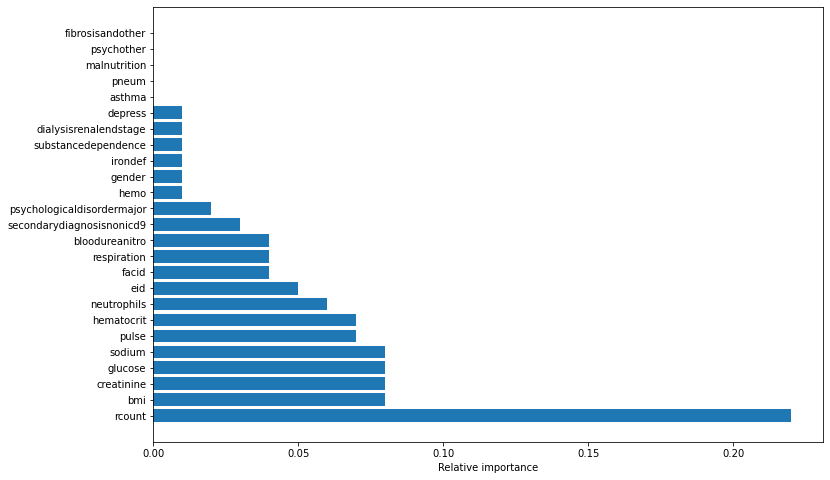

In [32]:
f, ax = plt.subplots(figsize=(12,8))
plt.barh(X.columns[indices], np.round(importances[indices],2))
plt.xlabel("Relative importance")
plt.show()

We notice that the model depends quite a bit on the `rcount` feature. That's not very surprising considering the correlations we found above.

As we remember from Lab 0, one shouldn't trust this way of computing feature importance. It's better to use a more data-driven technique, like for example **permutation importance**.

## Permutation importance

We recall from Lab 0 that the idea of permutation importance is that if a feature is important for the model then a random shuffling of the data in the corresponding column would result in a drastic deterioration of the model performance. If a feature is unimportant, then such shuffling wouldn't matter much. 

Let's try:

In [33]:
import eli5
from eli5.sklearn import PermutationImportance

D:\Anaconda3\envs\elmed219-2021\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda3\envs\elmed219-2021\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [34]:
perm = PermutationImportance(rf, random_state=42).fit(X_test, y_test)

In [35]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3913 ± 0.0037,rcount
0.1097 ± 0.0028,psychologicaldisordermajor
0.0772 ± 0.0041,facid
0.0728 ± 0.0038,hematocrit
0.0622 ± 0.0031,bmi
0.0592 ± 0.0036,creatinine
0.0564 ± 0.0033,sodium
0.0547 ± 0.0013,glucose
0.0524 ± 0.0028,pulse
0.0456 ± 0.0023,respiration


We notice that the model uses `rcount` as the most important feature also here, with a significant margin. 

> **Your turn!** An hypothesis for why `psychologicaldisordermajor` is high on the list of important features is that persons with this flag set to True are special in some impactful way. For example, one may wonder whether they are often in the "Behavioral" department.. Investigate this. Investigate also any other hypotheses you may think of. 

A natural question to ask is _"If the number of visits increase, does the length of stay also increase?"_. Or the other way around? Or is there a more complicated connection between the two?

We can (partly) uncover this by using **partial dependence plots**, as introduced in Lab 0.

## Partial dependence plots

What happens to the predicted length of stay if the number of visits increases?

In [36]:
from pdpbox import pdp

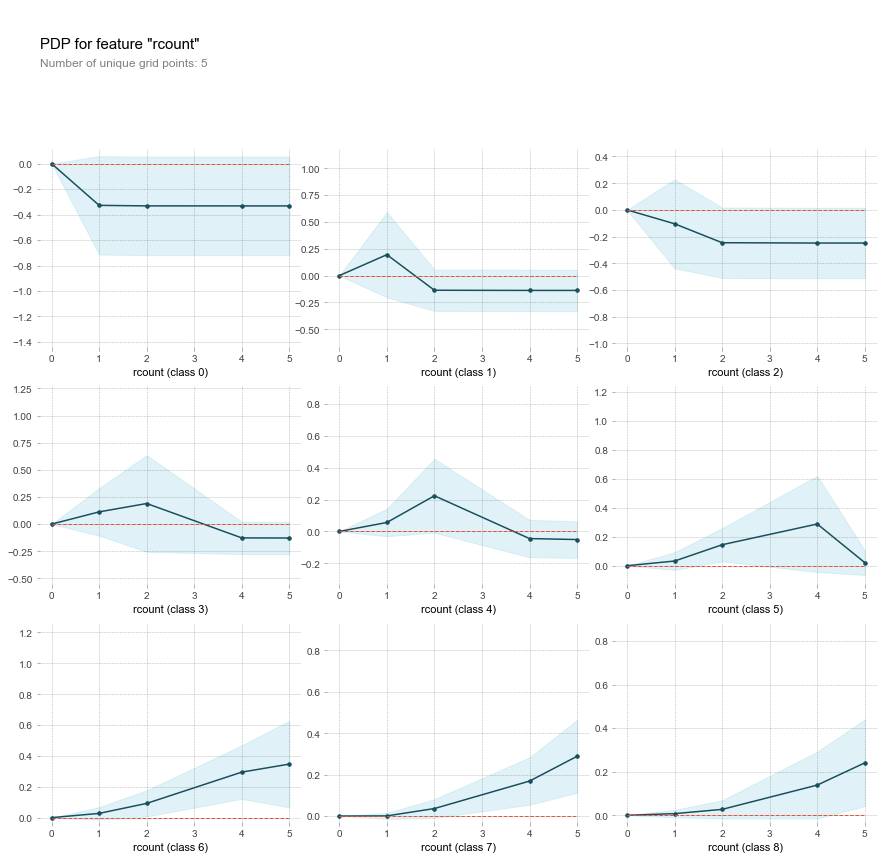

In [37]:
pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test, model_features=X_test.columns.tolist(), feature='rcount', n_jobs=-1)
pdp.pdp_plot(pdp_goals, 'rcount', ncols=3)
plt.show()

We see that for the short stays the expected number of days doesn't increase with the number of hospital visits. For the stays of 6 days or more, there is however such a connection.

> **Your turn!** What conditions (of those registered in our data set) characterizes patients with a high `rcount`?

# Feature engineering

Some features are more important than others for our model. In other words, some features describe the patients in a more expedient way than others, and are of greater value for our predictive model.

> But these are not necessarily the best features!

One of the most important parts of machine learning (albeit often underappreciated) is **feature engineering**.

As we've learned, machine learning is, basically, about **function approximation**. You want to find a function that is as close as possible to the true function mapping from the set of features to correct label or value.

> In general, the more _complicated_ the true function is, the harder it is for the machine learning model.

By describing the raw data with new, more suitable features it is possible to reduce the complexity of the true function. As an extreme example, if we had the date of entry and date of exit for each of our patients then the true function could be very simple: exit minus entry equals length of stay.

There's a lot of room between doing nothing and actually put the label as a feature (which is of course not useful). That's what feature engineering is about.

The best way to do feature engineering is to influence how the data is collected. Then it's possible to add new features that one believes could be useful for modelling (for example, we could add the patient age in our example).

If you cannot influence data collection one should rather think as follows: (i) bring in external features (f.ex. if we had the patients personal identification number we could access other data bases containing more information), or (ii) create new features by combine the ones we have.

> Any machine learning project will involve some feature engineering! (Deep learning is kind of an exception as we'll learn later).

## Creating a new feature

Each patient is associated to a number of flags for different conditions:
```
 'dialysisrenalendstage',
 'asthma',
 'irondef',
 'pneum',
 'substancedependence',
 'psychologicaldisordermajor',
 'depress',
 'psychother',
 'fibrosisandother',
 'malnutrition',
 'hemo'
 ```

In [38]:
LOS.head()

,rcount,gender,facid,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,lengthofstay
0,0,0,1,1,False,False,False,False,False,False,...,14.20,140.361130,192.476913,12.0,1.390722,30.432417,96,6.5,4,3
1,5,0,0,2,False,False,False,False,False,False,...,4.10,136.731689,94.078506,8.0,0.943164,28.460516,61,6.5,1,7
2,1,0,1,3,False,False,False,False,False,False,...,8.90,133.058517,130.530518,12.0,1.065750,28.843811,64,6.5,2,3
3,0,0,0,4,False,False,False,False,False,False,...,9.40,138.994019,163.377029,12.0,0.906862,27.959007,76,6.5,1,1
4,0,0,4,5,False,False,False,True,False,True,...,9.05,138.634842,94.886658,11.5,1.242854,30.258926,67,5.6,2,4


In [39]:
DICT

,Index,Data fields,Type,Descriptions
0,NaN,LengthOfStay,NaN,NaN
1,1.0,eid,Integer,Unique Id of the hospital admission
2,2.0,vdate,String,Visit date
3,3.0,rcount,Integer,Number of readmissions within last 180 days
4,4.0,gender,String,Gender of the patient\nM or F
5,5.0,dialysisrenalendstage,String,Flag for renal disease during encounter
6,6.0,asthma,String,Flag for asthma during encounter
7,7.0,irondef,String,Flag for iron deficiency during encounter
8,8.0,pneum,String,Flag for pneumonia during encounter
9,9.0,substancedependence,String,Flag for substance dependence during encounter


Let's make a feature that simply counts all the issues per patient. The idea is that the number of issues influences the length of stay, and if we add it as a feature we make it simpler for the model to pick up on this.

In [40]:
issues = ['dialysisrenalendstage',
 'asthma',
 'irondef',
 'pneum',
 'substancedependence',
 'psychologicaldisordermajor',
 'depress',
 'psychother',
 'fibrosisandother',
 'malnutrition',
 'hemo']

In [41]:
LOS.insert(len(LOS.columns)- 1, 'numberofissues', LOS[issues].astype('int').sum(axis=1))

In [42]:
LOS.head()

,rcount,gender,facid,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,numberofissues,lengthofstay
0,0,0,1,1,False,False,False,False,False,False,...,140.361130,192.476913,12.0,1.390722,30.432417,96,6.5,4,0,3
1,5,0,0,2,False,False,False,False,False,False,...,136.731689,94.078506,8.0,0.943164,28.460516,61,6.5,1,0,7
2,1,0,1,3,False,False,False,False,False,False,...,133.058517,130.530518,12.0,1.065750,28.843811,64,6.5,2,0,3
3,0,0,0,4,False,False,False,False,False,False,...,138.994019,163.377029,12.0,0.906862,27.959007,76,6.5,1,0,1
4,0,0,4,5,False,False,False,True,False,True,...,138.634842,94.886658,11.5,1.242854,30.258926,67,5.6,2,2,4


In [43]:
LOS['numberofissues'].value_counts()

0    57341
1    23350
2    11536
3     4660
4     2018
5      773
6      261
7       46
8       12
9        3
Name: numberofissues, dtype: int64

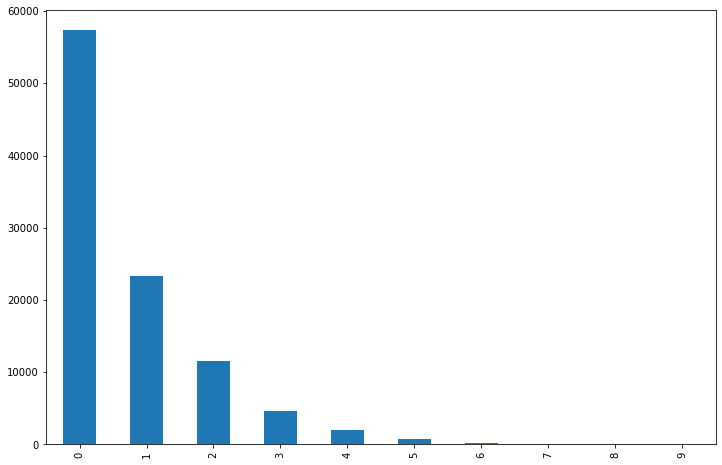

In [44]:
plt.figure(figsize=(12,8))
LOS['numberofissues'].value_counts().plot.bar()
plt.show()

> **Your turn!** Are patients with a large number of issues often at the hospital? Do they stay for long?

## Create a new model with our new feature included

In [45]:
X = LOS.drop('lengthofstay', axis=1)
y = LOS['lengthofstay']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [47]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) 

In [48]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [49]:
y_pred = rf.predict(X_test)

In [50]:
accuracy_score(y_test, y_pred)

0.67816

We are now predicting the length of stay with an accuracy of ca. 68%. A small improvement.

We can have a look at the feature importance and permutation importance to see how useful our new feature is:

In [51]:
importances = rf.feature_importances_
# Find index of those with highest importance, sorted from largest to smallest:
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]): 
    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

rcount: 0.23
creatinine: 0.08
glucose: 0.08
bmi: 0.08
sodium: 0.08
pulse: 0.07
hematocrit: 0.07
neutrophils: 0.05
numberofissues: 0.05
eid: 0.05
respiration: 0.04
bloodureanitro: 0.04
facid: 0.03
secondarydiagnosisnonicd9: 0.02
psychologicaldisordermajor: 0.01
gender: 0.01
hemo: 0.01
irondef: 0.0
substancedependence: 0.0
depress: 0.0
psychother: 0.0
pneum: 0.0
malnutrition: 0.0
dialysisrenalendstage: 0.0
asthma: 0.0
fibrosisandother: 0.0


We note that the model relies on the new feature more heavily than any of the separate flags. 

What about permuatation importance?

In [52]:
perm = PermutationImportance(rf, random_state=42).fit(X_test, y_test)

In [53]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=None)

Weight,Feature
0.4000 ± 0.0026,rcount
0.2792 ± 0.0051,numberofissues
0.0683 ± 0.0018,hematocrit
0.0596 ± 0.0028,bmi
0.0560 ± 0.0036,glucose
0.0553 ± 0.0018,creatinine
0.0547 ± 0.0030,sodium
0.0512 ± 0.0032,pulse
0.0437 ± 0.0023,respiration
0.0239 ± 0.0020,neutrophils


Here the effect of our new feature is shown to be very large! It ended up in second place, far above the rest.

# Your turn!

We've downloaded another classification data set and placed it in the folder `data/liver/indian_liver_patient.csv`. It consists of 416 _liver patients_ and 167 _non liver patients_ collected at Andhra Pradesh, India. It's described in detail here: https://archive.ics.uci.edu/ml/datasets/ILPD+(Indian+Liver+Patient+Dataset). From 10 features the task is to predict whether an instance corresponds to a patient or non-patient. 

Load the data using Pandas, explore as above, and try to predict the patient status.

**Hint:**

In [60]:
#df = pd.read_csv('data/indian_liver_patient.csv')

# Extra material



Our accuracy of 68% isn't that great. How would you go about improving it? In general, how do you improve a machine learning model's performance? Here are some standard ways (note that this gets a bit technical...):

1. Collect better data. Perhaps the problem was framed wrong during data collection? Is the data collected in a prudent way, fit for your purpose?
2. Get more data. Real data, synthesized data, or similar data.
3. Create new, better features. Also consider removing uninformative features (these can reduce performance by increasing data size requirements)
4. Preprocess the data better. Scaling, transformations, etc
5. Use a better adapted model. Most ML models can be tuned by selecting better hyperparameters. They can be made more or less complex, which is useful when trying to approximate the true function of a given complexity. _"Everything should be made as simple as possible, but not simpler"_.
6. Use a different class of model. Perhaps you've used a model that cannot become sufficiently complex ? Or perhaps your model is too complex?
7. Use multiple models together in an ensemble. For example using hard or soft voting. Or let each model be based on slightly different features than the others, making the models more independent of each other. You can also use a model to learn how the ensemble should best be combined, or sequentially train models trying to predict the errors of the previous models and then combine them to produce predictions.


Let's make an attempt at number 6: using a different model.

## XGBoost

XGBoost is one of the most powerful machine learning models.

We won't talk about how it works (but you can read about it about it <a href="https://xgboost.readthedocs.io/en/latest/tutorials/model.html">here</a> or <a href="https://www.gormanalysis.com/blog/gradient-boosting-explained/">here</a> or <a href="https://campus.datacamp.com/courses/extreme-gradient-boosting-with-xgboost/classification-with-xgboost">here</a>)

In [61]:
import sys
!{sys.executable} -m pip install xgboost

In [62]:
from xgboost import XGBClassifier

In [63]:
xgb_clf = XGBClassifier()

In [64]:
xgb_clf.fit(X_train, y_train)

[16:27:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
xgb_clf.score(X_test, y_test)

0.71768

Better than the random forest! And the story doesn't end there. The default values of various parameters in XGBoost (those listed when we wrote `xgb_clf.fit(X_train, y_train)` above) are rarely very good. It's important to use parameters that are adapted to the problem at hand. 

This can be achieved through what's called **hyperparameter search**. That's beyond what we want to discuss in the course, but I did a quick search and found the following parameters:

In [66]:
xgb_clf = XGBClassifier(max_depth=15, min_child_weight=15, random_state=0, n_estimators=300, n_jobs=-1)

In [67]:
xgb_clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=15,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [68]:
xgb_clf.fit(X_train, y_train)

[16:30:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=15, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
xgb_clf.score(X_test, y_test)

0.74604

The model has an accuracy of 74.6%. 

Let's compute the permutation importance:

In [70]:
perm = PermutationImportance(xgb_clf, random_state=42)

In [71]:
perm.fit(X_test, y_test)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_delta_step=0, max_depth=15,
                                              min_child_weight=15, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=300, n_jobs=-1,
                                              num_parallel_tree=1,
                                              objective='multi:softprob',
                                     

In [72]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.4508 ± 0.0022,rcount
0.3440 ± 0.0068,numberofissues
0.1052 ± 0.0043,bmi
0.1032 ± 0.0046,hematocrit
0.1004 ± 0.0016,glucose
0.0992 ± 0.0052,sodium
0.0987 ± 0.0031,creatinine
0.0971 ± 0.0040,pulse
0.0880 ± 0.0036,respiration
0.0381 ± 0.0026,neutrophils


> **Your turn!** How would a logistic regression model do?

> Hint: `from sklearn.linear_model import LogisticRegression`